In [1]:
import os 
import datetime 

def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)

#mac系统上pytorch和matplotlib在jupyter中同时跑需要更改环境变量
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" 

### 1. 准备数据

In [2]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt 
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [3]:
torch.manual_seed(0)

#样本数量
n = 400

# 生成测试用数据集
X = 10 * torch.rand([n, 2]) - 5.0  #rand均匀分布; X： 400*2 (-5, 5)均匀分布
w0 = torch.tensor([[2.0], [-3.0]]) # w0: 2*1
b0 = torch.tensor([[10.0]]) 

# 增加正态扰动
Y = X @ w0 + b0 + torch.normal(0.0, 2.0, size = [n, 1]) # 离散正态分布, mean = 0, std = 2
# X = [x1, x2] w0 = [2, 3]T Y = 2x1 - 3x2 + ... 
# x1: 400*1, x2:400*1, Y:400*1

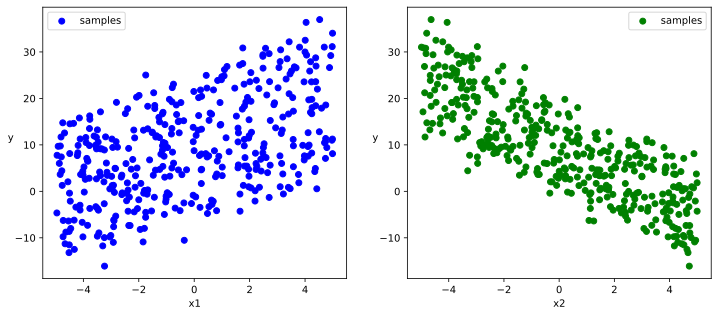

In [4]:
# 数据可视化
%matplotlib inline 
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize=(12, 5))

# 绘制多个子图，1*2划分的第1个子图
ax1 = plt.subplot(121)
ax1.scatter(X[:, 0].numpy(), Y[:, 0].numpy(), c = 'b', label = 'samples')
ax1.legend()
plt.xlabel('x1')
plt.ylabel('y', rotation = 0)

ax2 = plt.subplot(122)
ax2.scatter(X[:, 1].numpy(), Y[:, 0].numpy(), c = 'g', label = 'samples')
ax2.legend()
plt.xlabel('x2')
plt.ylabel('y', rotation = 0)

plt.show()

### 2. 构建数据管道

```python
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
```

In [5]:
ds = TensorDataset(X, Y)
train_size = int(n*0.7)
test_size = n - train_size
ds_train, ds_valid = torch.utils.data.random_split(ds, [train_size, test_size])
dl_train = DataLoader(ds_train, shuffle = True, batch_size = 10)
dl_valid = DataLoader(ds_valid, shuffle = True, batch_size = 10)

### 3. 定义模型

In [6]:
import torchkeras

def LR():
    net = nn.Sequential()
    net.add_module("Linear1", nn.Linear(2, 1))
    
    return net

model = LR()

In [7]:
from torchkeras import summary
summary(model, input_shape = (2, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 1]               3
Total params: 3
Trainable params: 3
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.000008
Forward/backward pass size (MB): 0.000008
Params size (MB): 0.000011
Estimated Total Size (MB): 0.000027
----------------------------------------------------------------


In [8]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
Linear1.weight 	 torch.Size([1, 2])
Linear1.bias 	 torch.Size([1])


### 4. 训练模型

In [9]:
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# mean_absolute_error
metric_func1 = lambda y_pred, y_true: torch.mean(torch.abs(y_pred - y_true))
metric_name1 = "mae"

# mean_absolute_percent_error
metric_func2 = lambda y_pred, y_true: torch.mean((torch.abs(y_pred - y_true) + 1e-7) / (torch.abs(y_true) + 1e-7))
metric_name2 = "mape"

# 训练循环
def train_step(model, features, labels):
    predictions = model(features)
    loss = loss_func(predictions, labels)
    metric1 = metric_func1(predictions, labels)
    metric2 = metric_func2(predictions, labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item(), metric1.item(), metric2.item()

# 验证循环
def eval_step(model, features, labels):
    with torch.no_grad():
        predictions = model(features)
        val_loss = loss_func(predictions, labels)
        metric1 = metric_func1(predictions, labels)
        metric2 = metric_func2(predictions, labels)
    return val_loss.item(), metric1.item(), metric2.item()


In [10]:
# 测试train_step
features, labels = next(iter(dl_train))
print(train_step(model, features, labels))

# 测试eval_step
features, labels = next(iter(dl_valid))
print(eval_step(model, features, labels))

(162.88739013671875, 10.327569961547852, 0.8398022651672363)
(238.48568725585938, 12.284849166870117, 0.9863737225532532)


In [11]:
dfhistory = pd.DataFrame(columns=["epochs", "loss", "mae", "mape", "val_loss", "val_mae", "val_mape"])

def train_model(model, epochs):
    for epoch in range(1, epochs+1):
        loss_sum = 0.0
        metric_mae_sum = 0.0
        metric_mape_sum = 0.0
        
        val_loss_sum = 0.0
        val_metric_mae_sum = 0.0
        val_metric_mape_sum = 0.0
        tstep = 1
        vstep = 1
        
        # 训练循环
        for tstep, (features, labels) in enumerate(dl_train, 1):
            loss, mae, mape = train_step(model, features, labels)
            loss_sum += loss
            metric_mae_sum += mae
            metric_mape_sum += mape
                  
        # 验证循环
        for vstep, (features, labels) in enumerate(dl_valid, 1):
            val_loss, val_mae, val_mape = eval_step(model, features, labels)
            val_loss_sum += val_loss
            val_metric_mae_sum += val_mae
            val_metric_mape_sum += val_mape
        
        # 记录
        info = (epoch, loss_sum/tstep, metric_mae_sum/tstep, metric_mape_sum/tstep,
                val_loss_sum/vstep, val_metric_mae_sum/vstep, val_metric_mape_sum/vstep)
        dfhistory.loc[epoch-1] = info
            
        if epoch%50 == 0:
            printbar()
            print("epoch = %d, loss = %.3f, mae = %.3f, mape = %.3f, val_loss = %.3f, val_mae = %.3f, val_mape = %.3f"%info)
            w = model.state_dict()["Linear1.weight"]
            b = model.state_dict()["Linear1.bias"]
            print("w =", w)
            print("b =", b)

In [12]:
train_model(model, epochs = 200)


================================================================================2020-12-10 15:38:27
epoch = 50, loss = 5.028, mae = 1.780, mape = 1.147, val_loss = 4.131, val_mae = 1.725, val_mape = 0.444
w = tensor([[ 1.9836, -3.0250]])
b = tensor([9.0331])

================================================================================2020-12-10 15:38:28
epoch = 100, loss = 4.226, mae = 1.614, mape = 0.941, val_loss = 3.664, val_mae = 1.527, val_mape = 0.448
w = tensor([[ 1.9996, -3.0195]])
b = tensor([9.8919])

================================================================================2020-12-10 15:38:29
epoch = 150, loss = 4.241, mae = 1.622, mape = 0.952, val_loss = 3.743, val_mae = 1.554, val_mape = 0.450
w = tensor([[ 2.0276, -3.0232]])
b = tensor([9.8810])

================================================================================2020-12-10 15:38:29
epoch = 200, loss = 4.238, mae = 1.627, mape = 0.956, val_loss = 3.785, val_mae = 1.562, val_mape = 0.451
w = tensor(

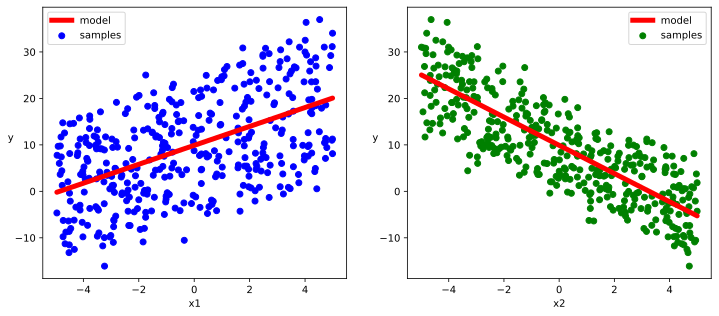

In [13]:
# 结果可视化

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize=(12, 5))

w, b = model.state_dict()["Linear1.weight"], model.state_dict()["Linear1.bias"]

ax1 = plt.subplot(121)
ax1.scatter(X[:, 0], Y[:, 0], c = "b", label = "samples")
ax1.plot(X[:,0], w[0, 0]*X[:, 0]+b[0], "-r", linewidth = 5.0, label = "model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y", rotation = 0)

ax2 = plt.subplot(122)
ax2.scatter(X[:, 1], Y[:, 0], c = "g", label = "samples")
ax2.plot(X[:, 1], w[0, 1]*X[:, 1]+b[0], "-r", linewidth = 5.0, label = "model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y", rotation = 0)

plt.show()

### 5. 评估模型

In [14]:
dfhistory.tail()

,epochs,loss,mae,mape,val_loss,val_mae,val_mape
195,196.0,4.228449,1.614004,0.938762,3.756861,1.554153,0.449684
196,197.0,4.234710,1.621144,0.954986,3.688023,1.533643,0.448004
197,198.0,4.237015,1.616255,0.924959,3.684683,1.531254,0.448893
198,199.0,4.252285,1.616124,0.920982,3.664655,1.525571,0.446762
199,200.0,4.238493,1.627419,0.956284,3.784926,1.562307,0.451298


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


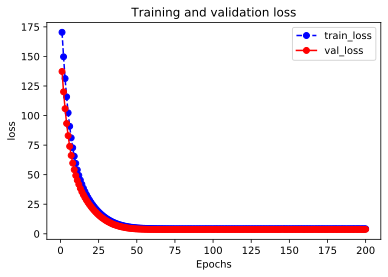

In [15]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

plot_metric(dfhistory, "loss")

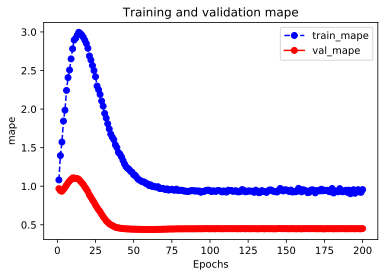

In [16]:
plot_metric(dfhistory, "mape")